In [1]:
import glob
from timeit import default_timer as timer

import torch
import clip
from PIL import Image

import numpy as np
import pandas as pd
from tqdm import tqdm
import os
from pathlib import Path
import matplotlib.pyplot as plt
import scipy.special

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [25]:
# CONSTANTS
MODEL = "ViT-L-14"
DATASET = "PH2"
ADDITIONAL_COMMENTS = "CLASS_LABELS_PROMPTS"

In [4]:
# 1. Load Model and Processor
print("[INFO] Loading model...")

if MODEL == "ViT-B-32":
    model, preprocess = clip.load("ViT-B/32", device=device)
elif MODEL == "ViT-B-16":
    model, preprocess = clip.load("ViT-B/16", device=device)
elif MODEL == "RN50":
    model, preprocess = clip.load("RN50", device=device)
elif MODEL == "RN101":
    model, preprocess = clip.load("RN101", device=device)
elif MODEL == "ViT-L-14":
    model, preprocess = clip.load("ViT-L/14", device=device)
elif MODEL == "RN50x16":
    model, preprocess = clip.load("RN50x16", device=device)
elif MODEL == "ViT-B-32-FT":
    model, preprocess = clip.load("ViT-B/32", device=device)
    checkpoint = torch.load("ft_models/CLIP_D7PT_ViT-B-32_best.pt")
    model.load_state_dict(checkpoint['model_state_dict'])
elif MODEL == "ViT-B-16-FT":
    model, preprocess = clip.load("ViT-B/16", device=device)
    checkpoint = torch.load("ft_models/model_D7PT_ViT16.pt")
    model.load_state_dict(checkpoint['model_state_dict'])

print("[INFO] Model loaded successfully!")

[INFO] Loading model...
[INFO] Model loaded successfully!


In [5]:
CLASS_LABELS_PROMPTS = {
    "Melanoma": ["This is dermatoscopy of melanoma"],
    "Nevus": ["This is dermatoscopy of nevus"]
}

In [6]:
REFERENCE_CONCEPT_PROMPTS = ["This is dermatoscopy"]

In [7]:
# Extract text features for each concept and save it to a numpy array
for disease_label in CLASS_LABELS_PROMPTS.keys():
    text = clip.tokenize(CLASS_LABELS_PROMPTS[disease_label]).to(device)

    with torch.no_grad():
        text_features = model.encode_text(text)
    
    text_features /= text_features.norm(dim=-1, keepdim=True)
    
    np.save(f"text_embeddings/class_label_embeddings_{disease_label}_{MODEL}.npy", text_features.detach().cpu().numpy())
print("[INFO] Completed!")

[INFO] Completed!


In [8]:
# Extract text features for each concept and save it to a numpy array
text = clip.tokenize(REFERENCE_CONCEPT_PROMPTS).to(device)
with torch.no_grad():
    text_features = model.encode_text(text)

text_features /= text_features.norm(dim=-1, keepdim=True)

np.save(f"concept_embeddings/reference_embeddings_{MODEL}.npy", text_features.detach().cpu().numpy())
print("[INFO] Completed!")

[INFO] Completed!


In [9]:
from scipy.special import softmax

def get_similarity_score(image_features, text_features):
    similarity = np.dot(image_features, text_features.T)

    return similarity

In [10]:
def calculate_similarity_score(image_features_norm,
                               prompt_target_embedding_norm,
                               prompt_ref_embedding_norm,
                               temp=1,
                               top_k=-1,
                               normalize=True):

    #rint(image_features_norm.shape)
    #print(prompt_target_embedding_norm.shape)
    #print(prompt_ref_embedding_norm.shape)

    target_similarity = prompt_target_embedding_norm.float() @ image_features_norm.T.float()
    ref_similarity = prompt_ref_embedding_norm.float() @ image_features_norm.T.float()


    if top_k > 0:
        idx_target = target_similarity.argsort(dim=1, descending=True)
        target_similarity_mean = target_similarity[:,idx_target.squeeze()[:top_k]].mean(dim=1)
        
        ref_similarity_mean = ref_similarity.mean(dim=1)
    else:
        target_similarity_mean = target_similarity.mean(dim=1)
        ref_similarity_mean = ref_similarity.mean(dim=1)
    
    if normalize:
        similarity_score = scipy.special.softmax([target_similarity_mean.numpy(), ref_similarity_mean.numpy()], axis=0)[0, :].mean(axis=0)
    else:
        similarity_score = target_similarity_mean.mean(axis=0)

    return similarity_score

In [26]:
# Get image embeddings 
print(f"[INFO] DATASET: {DATASET}")
print(f"[INFO] MODEL: {MODEL}")
RANDOM_SEED = 42
N_SAMPLES = 80

#img_embeddings = np.load(f"img_embeddings/image_embeddings_{DATASET}_{MODEL}_{RANDOM_SEED}_Segmented_Norm.npy", allow_pickle=True).item()
img_embeddings = np.load(f"img_embeddings/image_embeddings_{DATASET}_CLIP_{MODEL}_Segmented_Norm.npy", allow_pickle=True).item()
reference_embeddings = torch.from_numpy(np.load(f"concept_embeddings/reference_embeddings_{MODEL}.npy")).unsqueeze(0)
#img_embeddings = np.load(f"img_embeddings/image_embeddings_derm7pt_{MODEL}_{RANDOM_SEED}_{N_SAMPLES}_samples_per_class_Segmented_Norm.npy", allow_pickle=True).item()
#reference_embeddings = torch.from_numpy(np.load(f"concept_embeddings/reference_embeddings_RN50x16.npy")).unsqueeze(0)

results = dict()
# Iterate over images and calculate similarity
for im in img_embeddings.keys():
    img_feats = torch.from_numpy(img_embeddings[im]).unsqueeze(0)
    #print(f"IMG shape: {img_feats.shape}")

    similarity_scores = []
    for disease_label in CLASS_LABELS_PROMPTS.keys():
        #text_feats = torch.from_numpy(np.load(f"text_embeddings/class_label_embeddings_{disease_label}_{DATASET}_{MODEL}_{RANDOM_SEED}.npy")).unsqueeze(0)
        #text_feats = torch.from_numpy(np.load(f"text_embeddings/class_label_embeddings_{disease_label}_{DATASET}_{MODEL}.npy")).unsqueeze(0)
        text_feats = torch.from_numpy(np.load(f"text_embeddings/class_label_embeddings_{disease_label}_{MODEL}.npy")).unsqueeze(0)
        #print(f"TEXT shape: {text_feats.shape}")

        #similarity = get_similarity_score(img_feats, text_feats)
        similarity = calculate_similarity_score(image_features_norm=img_feats,
                                                prompt_target_embedding_norm=text_feats,
                                                prompt_ref_embedding_norm=reference_embeddings,
                                                top_k=-1,
                                                temp=(1/np.exp(4.5944)),
                                                normalize=True)

        similarity_scores.append(similarity[0])

    # Calculate prediction given weights of melanoma
    results[im] = similarity_scores

[INFO] DATASET: PH2
[INFO] MODEL: ViT-L-14


In [27]:
# Evaluation
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, balanced_accuracy_score, auc

if DATASET == "PH2":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/PH2Dataset/PH2_dataset.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_train.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_validation.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/PH2_test.csv")
    test_images = test_images_df["images"].tolist()

elif DATASET == "derm7pt":
    gt = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Datasets/Skin/Derm7pt/image_classes_derm7pt.csv")
    
    train_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_train_seg.csv")
    train_images = train_images_df["images"].tolist()
    
    valiadtion_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_validation_seg.csv")
    validation_images = valiadtion_images_df["images"].tolist()
    
    test_images_df = pd.read_csv("/home/cristianopatricio/Desktop/PhD/Methods/CCNN_Pytorch/data/derm7pt_test_seg.csv")
    test_images = test_images_df["images"].tolist()

y_true_val = []
y_pred_probs_val = []
for im in results.keys():

    if str(im) in validation_images:
        y_true_val.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred_probs_val.append(np.max(results[im]))

fpr, tpr, thresholds = roc_curve(y_true_val, y_pred_probs_val)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

y_true = []
y_pred = []
y_pred_probs = []
for im in results.keys():
    
    if str(im) in test_images:
        y_true.append(gt.loc[gt['images'] == str(im)]['labels'].tolist()[0])
        y_pred.append(1 if np.max(results[im]) > optimal_threshold else 0)
        y_pred_probs.append(np.max(results[im]))

print(classification_report(y_true=y_true, y_pred=y_pred, target_names=["NEV", "MEL"]))

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
TP = conf_matrix[1][1]
TN = conf_matrix[0][0]
FP = conf_matrix[0][1]
FN = conf_matrix[1][0]
print(conf_matrix)

# Calculate AUC score
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc}")

# BACC
bacc = balanced_accuracy_score(y_true, y_pred)
print(f"BACC: {bacc}")

# Sensitivity
SE = TP / (TP + FN)
print(f"Sensitivity: {SE}")

# Specificity
SP = TN / (TN + FP)
print(f"Specificity: {SP}")

Threshold value is: 0.5005883
              precision    recall  f1-score   support

         NEV       1.00      0.60      0.75        20
         MEL       0.38      1.00      0.56         5

    accuracy                           0.68        25
   macro avg       0.69      0.80      0.65        25
weighted avg       0.88      0.68      0.71        25

[[12  8]
 [ 0  5]]
AUC: 0.87
BACC: 0.8
Sensitivity: 1.0
Specificity: 0.6


In [22]:
# function to add to JSON
import json

def write_json(new_data, filename='results_file.json'):
    with open(filename,'r+') as file:
          # First we load existing data into a dict.
        file_data = json.load(file)
        # Join new_data with file_data inside emp_details
        file_data[DATASET].append(new_data)
        # Sets file's current position at offset.
        file.seek(0)
        # convert back to json.
        json.dump(file_data, file, indent = 4)
 
# python object to be appended
new_entry = {"model": MODEL + "_" + str(RANDOM_SEED) + "_" + str(N_SAMPLES) + "_samples",
             "AUC": roc_auc,
             "BACC": bacc,
             "SE": SE,
             "SP": SP
            }
     
write_json(new_entry)

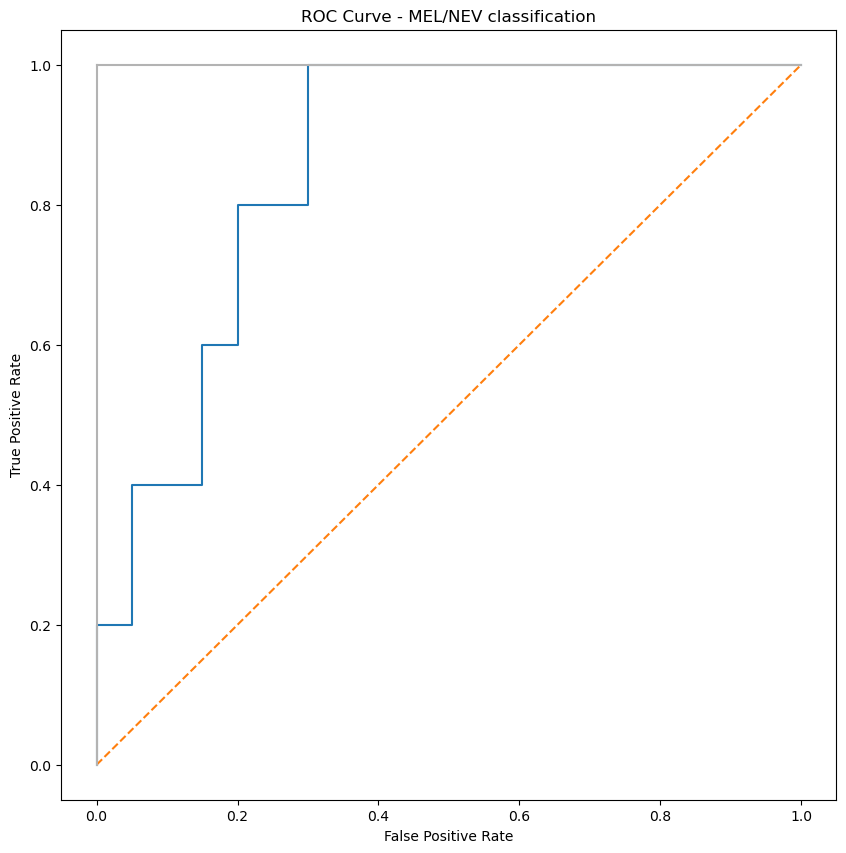

In [19]:
# Plot ROC AUC curve
import matplotlib.pyplot as plt

plt.subplots(1, figsize=(10,10))
plt.title('ROC Curve - MEL/NEV classification')
plt.plot(fpr, tpr)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()